# Meteor Project - Meteor showers in the sky

This notebook will take a look at one of the "most important" property of meteors: the radiant. This feature is plotted on sky maps and each dot represents the direction where a meteor came from (like the vanishing point on images).

## Loading and filtering data

In [1]:
# Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import datetime
import math
import os

In [2]:
# Read in the meteor data
df_orbit_compl = pd.read_csv("meteor_data/meteor_compl.csv",
                             index_col=0)
df_orbit_error = pd.read_csv("meteor_data/meteor_error.csv",
                             index_col=0)

In [3]:
# Reminder how the data looks like
df_orbit_compl

,Yr,Mn,Dayy,mv,RA,DECL,Vg,Vh,q,e,a1,a,i,arg,nod,pi
227045,2014,1,1.07498,0.6,6.57,22.73,9.10,39.03,0.9829,0.68830,0.317,3.15,4.18,182.77,280.354,103.12
227046,2014,1,1.08234,1.3,100.48,43.22,13.73,33.73,0.7289,0.45230,0.751,1.33,8.69,260.26,280.365,180.62
227047,2014,1,1.09662,1.5,65.46,-28.34,13.43,38.36,0.9489,0.64400,0.375,2.67,15.53,24.41,100.386,124.80
227048,2014,1,1.09760,0.6,332.68,-9.98,8.57,37.32,0.9545,0.55730,0.464,2.16,0.28,156.74,280.250,76.99
227049,2014,1,1.12450,0.0,114.25,21.80,29.04,37.37,0.3487,0.83980,0.459,2.18,0.27,294.62,280.244,214.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698622,2010,12,27.48756,0.4,220.89,21.10,53.31,36.91,0.6664,0.66796,0.498,2.01,106.86,101.25,275.453,16.70
698623,2010,12,27.51962,1.8,201.44,38.82,54.13,38.43,0.9750,0.64062,0.369,2.71,103.37,192.08,275.486,107.57
698624,2010,12,27.52003,1.7,158.74,19.23,63.62,41.92,0.3459,0.98170,0.053,18.90,155.08,287.97,275.487,203.46
698625,2010,12,27.55850,-0.8,168.11,26.88,66.19,44.20,0.5904,1.09978,-0.169,999.00,137.87,256.30,275.526,171.83


In [4]:
df_orbit_error

,Yr,Mn,Dayy,mv,RA,DECL,Vg,Vh,q,e,a1,a,i,arg,nod,pi
0,2022,1,1.36141,1.3,65.589,38.787,12.424,37.891,0.889,0.6306,0.4155,2.407,5.7151,221.2093,280.6015,NaN
1,2022,1,1.36365,1.9,313.728,-22.221,12.562,38.041,0.880,0.6458,0.4026,2.484,1.5999,317.0225,100.5960,NaN
2,2022,1,1.37797,1.3,305.452,25.050,14.408,38.657,0.923,0.6775,0.3494,2.862,15.1098,148.0460,280.6173,NaN
3,2022,1,1.39083,0.3,232.850,60.526,39.530,42.131,0.982,0.9676,0.0330,30.309,63.6963,184.5843,280.6299,NaN
4,2022,1,1.39433,-0.1,93.278,24.747,19.045,37.882,0.685,0.7147,0.4162,2.402,0.7777,254.1440,280.6460,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895544,2012,12,31.87218,-0.4,188.337,-8.629,72.131,42.027,0.983,0.9577,0.0430,23.247,172.0427,357.7996,100.4206,NaN
895545,2012,12,31.87269,-1.0,229.675,19.802,58.424,43.313,0.698,1.0564,-0.0807,-12.390,106.3832,115.8545,280.4203,NaN
895546,2012,12,31.87308,-2.3,164.473,13.363,65.079,41.898,0.395,0.9782,0.0551,18.138,164.7169,282.1166,280.4203,NaN
895547,2012,12,31.87690,0.4,175.746,12.941,69.996,43.410,0.715,1.0645,-0.0902,-11.083,160.3604,241.9048,280.4243,NaN


In [5]:
# We merge both dataframes and extract the columns of interest:
#     - RA: Right ascension of the radiant in degrees
#     - DECL: Declination of the radiant in degrees
#     - Vg: Geo-Centric velocity in km/s
#     - Yr, Mn, Dayy: Year, month and day+fraction of a day
df_radiants = pd.concat([df_orbit_compl[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]],
                         df_orbit_error[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]]])

In [6]:
# Filtering the data on the Vg limits (11 to 73 km/s)
# First, let's check how many data points we have
print(f"Number of meteor data before filtering: {len(df_radiants)}")

# Now filter
df_radiants = df_radiants.loc[(df_radiants["Vg"]>=11) & (df_radiants["Vg"]<=73)].copy()

print(f"Number of meteor data after filtering: {len(df_radiants)}")

Number of meteor data before filtering: 895549
Number of meteor data after filtering: 864308


## First sky map plotting

First, let's plot all data points in a sky map

In [7]:
# Checking the ranges of the RA and DECL values (we need to convert it for the matplotlib plotting
# function
print(f"Minimum RA value: {df_radiants.RA.min()}")
print(f"Maximum RA value: {df_radiants.RA.max()}")
print(f"Minimum DECL value: {df_radiants.DECL.min()}")
print(f"Maximum DECL value: {df_radiants.DECL.max()}")

Minimum RA value: 0.0
Maximum RA value: 360.0
Minimum DECL value: -89.37
Maximum DECL value: 89.88


In [8]:
# Convert to radians
df_radiants.loc[:, "RA_rad"] = np.radians(df_radiants["RA"])
df_radiants.loc[:, "DECL_rad"] = np.radians(df_radiants["DECL"])

In [9]:
# Add a column for the plot
df_radiants.loc[:, 'RA_rad4plot'] = \
    df_radiants['RA_rad'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

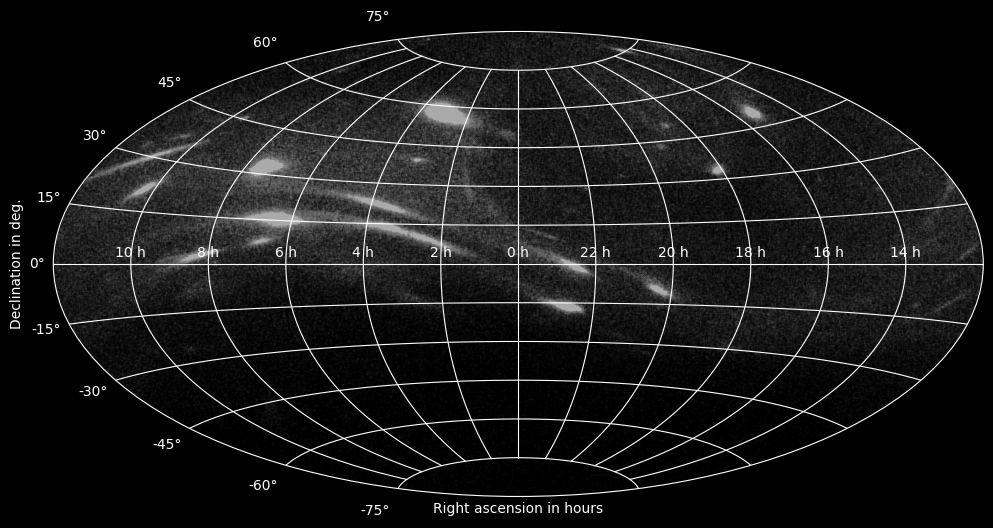

In [10]:
# Add some styles
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Plot the radiants
plt.scatter(df_radiants['RA_rad4plot'], \
            df_radiants['DECL_rad'], color='white', linestyle='None', \
            alpha=.01, s=1)

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

## Considering the velocity

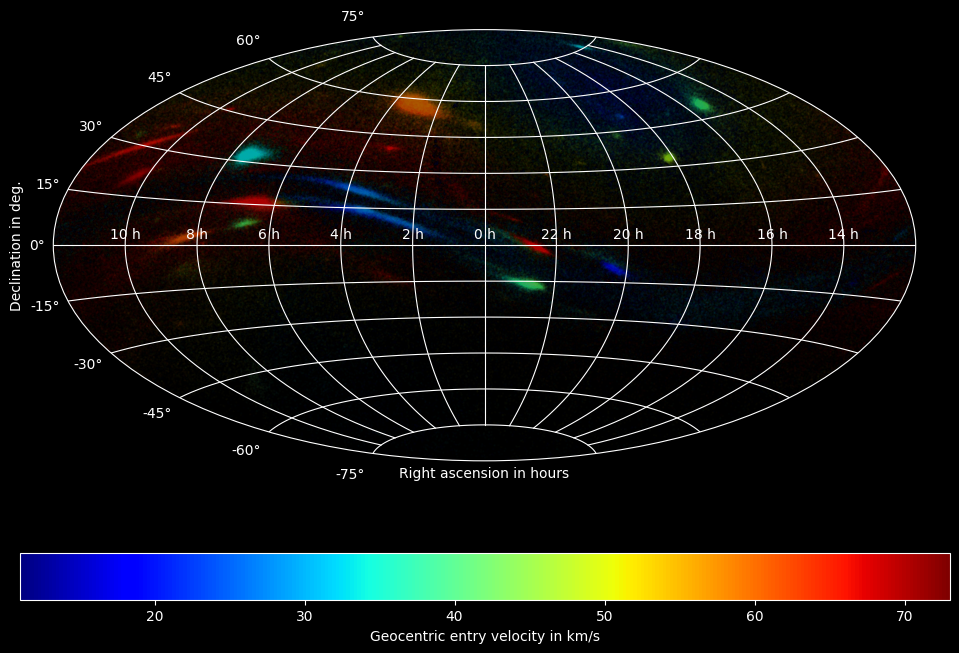

In [11]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Add a color for the velocity values
cm = plt.colormaps.get_cmap('jet')

# Plot the radiants
cr = plt.scatter(df_radiants['RA_rad4plot'], \
            df_radiants['DECL_rad'], linestyle='None', \
            alpha=.01, s=1, c=df_radiants["Vg"].values, cmap=cm)

# Create a colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(df_radiants["Vg"].values),
                                                       max(df_radiants["Vg"].values)))


# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

# Add the colorbar
ax = plt.gca()
color_bar = fig.colorbar(sm, orientation='horizontal', ax=ax)
color_bar.set_alpha(1)
color_bar.set_label('Geocentric entry velocity in km/s')

# A quick'n'dirty look at the Perseids

In [12]:
# The Perseids's are active between July and September with a peak around the 12th of August. Let's
# filter the data +/- 7 days around the 12th to see, where the Perseids come from.
# Spoiler: the appear to come from ... Perseus ...

# First we add a datetime object column:
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: datetime.datetime(year=int(x["Yr"]),
                                                  month=int(x["Mn"]),
                                                  day=math.floor(x["Dayy"])),
                                                  axis=1)

In [13]:
# Add now the day's fraction
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: x["datetime"] + datetime.timedelta(days=x["Dayy"]%1), axis=1)

In [14]:
# And let's take a look:
df_radiants

,RA,DECL,Vg,Yr,Mn,Dayy,RA_rad,DECL_rad,RA_rad4plot,datetime
227046,100.480,43.220,13.730,2014,1,1.08234,1.753707,0.754331,-1.753707,2014-01-01 01:58:34.176
227047,65.460,-28.340,13.430,2014,1,1.09662,1.142493,-0.494626,-1.142493,2014-01-01 02:19:07.968
227049,114.250,21.800,29.040,2014,1,1.12450,1.994039,0.380482,-1.994039,2014-01-01 02:59:16.800
227051,102.810,24.330,23.630,2014,1,1.14693,1.794373,0.424639,-1.794373,2014-01-01 03:31:34.752
227052,80.620,49.810,14.320,2014,1,1.14772,1.407084,0.869349,-1.407084,2014-01-01 03:32:43.008
...,...,...,...,...,...,...,...,...,...,...
895544,188.337,-8.629,72.131,2012,12,31.87218,3.287101,-0.150604,2.996085,2012-12-31 20:55:56.352
895545,229.675,19.802,58.424,2012,12,31.87269,4.008585,0.345610,2.274600,2012-12-31 20:56:40.416
895546,164.473,13.363,65.079,2012,12,31.87308,2.870595,0.233228,-2.870595,2012-12-31 20:57:14.112
895547,175.746,12.941,69.996,2012,12,31.87690,3.067346,0.225863,-3.067346,2012-12-31 21:02:44.160


In [15]:
# Now let's filter for the Perseids and let's check the plot again:
df_radiants_perseids_peak = \
df_radiants[(df_radiants["datetime"].dt.month == 8) &
            ((df_radiants["datetime"].dt.day >= 5) & (df_radiants["datetime"].dt.day <= 19))].copy()

In [16]:
df_radiants_perseids_peak

,RA,DECL,Vg,Yr,Mn,Dayy,RA_rad,DECL_rad,RA_rad4plot,datetime
256615,289.920,70.940,26.460,2014,8,5.17275,5.060059,1.238137,1.223127,2014-08-05 04:08:45.600
256616,189.750,32.420,12.460,2014,8,5.17608,3.311762,0.565836,2.971423,2014-08-05 04:13:33.312
256617,272.300,-1.050,12.250,2014,8,5.17635,4.752532,-0.018326,1.530654,2014-08-05 04:13:56.640
256618,296.230,34.800,23.180,2014,8,5.18053,5.170189,0.607375,1.112996,2014-08-05 04:19:57.792
256619,38.170,56.190,58.250,2014,8,5.18775,0.666192,0.980701,-0.666192,2014-08-05 04:30:21.600
...,...,...,...,...,...,...,...,...,...,...
876222,73.941,27.286,68.458,2012,8,19.80725,1.290514,0.476231,-1.290514,2012-08-19 19:22:26.400
876223,31.414,10.474,63.331,2012,8,19.80813,0.548278,0.182806,-0.548278,2012-08-19 19:23:42.432
876224,60.179,61.243,58.318,2012,8,19.81574,1.050322,1.068892,-1.050322,2012-08-19 19:34:39.936
876225,66.274,63.329,56.516,2012,8,19.81944,1.156700,1.105300,-1.156700,2012-08-19 19:39:59.616


Text(0.5, 1.0, "Radiants around the Perseids' peak")

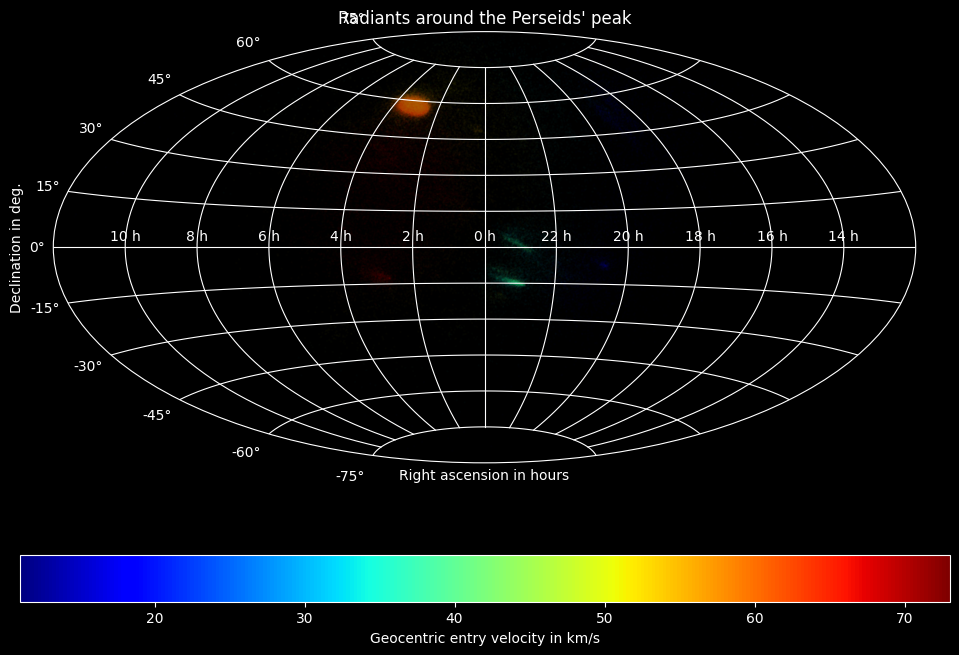

In [17]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Add a color for the velocity values
cm = plt.colormaps.get_cmap('jet')

# Plot the radiants
cr = plt.scatter(df_radiants_perseids_peak['RA_rad4plot'], \
            df_radiants_perseids_peak['DECL_rad'], linestyle='None', \
            alpha=.01, s=1, c=df_radiants_perseids_peak["Vg"].values, cmap=cm)

# Create a colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(df_radiants_perseids_peak["Vg"].values),
                                                       max(df_radiants_perseids_peak["Vg"].values)))


# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

# Add the colorbar
ax = plt.gca()
color_bar = fig.colorbar(sm, orientation='horizontal', ax=ax)
color_bar.set_alpha(1)
color_bar.set_label('Geocentric entry velocity in km/s')

plt.title("Radiants around the Perseids' peak")